In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from omegaconf import OmegaConf
from plaid.datasets import NUM_ORGANISM_CLASSES, NUM_FUNCTION_CLASSES
import hydra
from plaid.pipeline import SampleLatent
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda")

/homefs/home/lux70/code/plaid/src/plaid/denoisers/modules/_attention.py:12: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  from xformers.components.attention import ScaledDotProduct


In [3]:
with open("/homefs/home/lux70/code/plaid/best_idxs.txt", "r") as f:
    lines = f.readlines()
lines = [int(x.rstrip("\n")) for x in lines]
lines

[547, 192, 169, 29, 38, 229, 86, 1907, 162, 1790, 1386, 1854, 641, 827, 1907]

In [4]:
go_idx_df = pd.read_csv("/data/lux70/data/pfam/go_index.csv")
go_idx_df

,Unnamed: 0,GO_term,pfam_id,GO_id,GO_level,count,GO_idx
0,161,G protein-coupled receptor activity,PF00001,GO:0004930,function,11,0
1,54,ATP hydrolysis activity,PF00004,GO:0016887,function,15,1
2,52,ATP binding,PF00006,GO:0005524,function,178,2
3,174,GTPase activity,PF00009,GO:0003924,function,10,3
4,1634,protein dimerization activity,PF00010,GO:0046983,function,22,4
...,...,...,...,...,...,...,...
2214,249,RNA cap binding,PF21071,GO:0000339,function,1,2214
2215,730,deoxyribonuclease I activity,PF21111,GO:0004530,function,1,2215
2216,1599,potassium channel regulator activity,PF21201,GO:0015459,function,1,2216
2217,1180,microtubule,PF21410,GO:0005874,component,3,2217


In [5]:
import numpy as np
np.unique(go_idx_df.GO_level, return_counts=True)

(array(['component', 'function', 'process'], dtype=object),
 array([324, 945, 950]))

In [6]:
for idx in lines:
    tmp = go_idx_df[go_idx_df.GO_idx == idx]
    print(idx, tmp.GO_term.values[0], tmp.GO_id.values[0], "\t", tmp.GO_level.values[0])

547 metal ion transmembrane transporter activity GO:0046873 	 function
192 protein deubiquitination GO:0016579 	 process
169 kinase activity GO:0016301 	 function
29 phosphorelay signal transduction system GO:0000160 	 process
38 metal ion binding GO:0046872 	 function
229 zinc ion binding GO:0008270 	 function
86 regulation of DNA-templated transcription GO:0006355 	 process
1907 positive regulation of cyclin-dependent protein serine/threonine kinase activity GO:0045737 	 process
162 DNA-templated transcription initiation GO:0006352 	 process
1790 nuclear-transcribed mRNA catabolic process, nonsense-mediated decay GO:0000184 	 process
1386 oxidoreductase activity, acting on NAD(P)H, quinone or similar compound as acceptor GO:0016655 	 function
1854 telomere maintenance via telomerase GO:0007004 	 process
641 lysyl-tRNA aminoacylation GO:0006430 	 process
827 glucuronate isomerase activity GO:0008880 	 function
1907 positive regulation of cyclin-dependent protein serine/threonine kinas

In [7]:
import pandas as pd

pfam2go = pd.read_csv("/data/lux70/data/pfam/pfam2go.csv")
pfam2go.head()

,pfam_id,GO_id,GO_term,GO_level,count,GO_idx
0,PF00001,GO:0004930,G protein-coupled receptor activity,function,11,0
1,PF00002,GO:0004930,G protein-coupled receptor activity,function,11,0
2,PF00003,GO:0004930,G protein-coupled receptor activity,function,11,0
3,PF00004,GO:0016887,ATP hydrolysis activity,function,15,1
4,PF00005,GO:0016887,ATP hydrolysis activity,function,15,1


In [8]:
pfam2go[pfam2go.GO_id == "GO:0006352"]

,pfam_id,GO_id,GO_term,GO_level,count,GO_idx
237,PF00352,GO:0006352,DNA-templated transcription initiation,process,13,162
1458,PF02291,GO:0006352,DNA-templated transcription initiation,process,13,162
2105,PF03540,GO:0006352,DNA-templated transcription initiation,process,13,162
2534,PF04539,GO:0006352,DNA-templated transcription initiation,process,13,162
2535,PF04542,GO:0006352,DNA-templated transcription initiation,process,13,162
2537,PF04545,GO:0006352,DNA-templated transcription initiation,process,13,162
2722,PF04963,GO:0006352,DNA-templated transcription initiation,process,13,162


In [15]:
organism_df = pd.read_csv("/data/lux70/data/pfam/organism_hierarchy.csv")

In [16]:
organism_df.head()

,uniref_identifier,uniref_code,name,kingdom,superkingdom,phylum,class,order,family,genus,species,organism_index,counts
0,AADNV,648330,Aedes albopictus densovirus (isolate Boublik/1...,Shotokuvirae,Viruses,Cossaviricota,Quintoviricetes,Piccovirales,Parvoviridae,Brevihamaparvovirus,Brevihamaparvovirus dipteran1,3491,2
1,AAV2S,648242,Adeno-associated virus 2 (isolate Srivastava/1...,Shotokuvirae,Viruses,Cossaviricota,Quintoviricetes,Piccovirales,Parvoviridae,Dependoparvovirus,Dependoparvovirus primate1,3489,4
2,ABIDE,46125,Abiotrophia defectiva,NaN,Bacteria,Bacillota,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Abiotrophia defectiva,2236,2411
3,ABLVB,446561,Australian bat lyssavirus (isolate Bat/AUS/1996),Orthornavirae,Viruses,Negarnaviricota,Monjiviricetes,Mononegavirales,Rhabdoviridae,Lyssavirus,Lyssavirus australis,3422,8
4,ABPVR,1217067,Acute bee paralysis virus (strain Rothamsted),Orthornavirae,Viruses,Pisuviricota,Pisoniviricetes,Picornavirales,Dicistroviridae,Aparavirus,Aparavirus apisacutum,3093,6


In [13]:
with open("/homefs/home/lux70/code/plaid/organisms.txt", "r") as f:
    orgs = f.readlines()
orgs = [int(x.rstrip("\n")) for x in orgs]
orgs

[758,
 1411,
 2436,
 158,
 1326,
 1294,
 300,
 799,
 1265,
 716,
 333,
 1357,
 1388,
 1452,
 818]

In [19]:
for o in orgs:
    print(o, organism_df[organism_df['organism_index'] == o].uniref_identifier.values)

758 ['BOVIN']
1411 ['CHICK']
2436 ['ECOLI']
158 ['HORSE']
1326 ['HUMAN']
1294 ['MAIZE']
300 ['MOUSE']
799 []
1265 ['RABIT']
716 []
333 ['SHEEP']
1357 ['SOYBN']
1388 ['TOBAC']
1452 ['WHEAT']
818 ['YEAST']


In [15]:
import pandas as pd
df = pd.read_parquet("/data/lux70/data/pfam/val.parquet")# df = pd.read_parquet("/data/lux70/data/pfam/val_shard_info.parquet")

In [16]:
lines

[547, 192, 169, 29, 38, 229, 86, 1907, 162, 1790, 1386, 1854, 641, 827]

In [17]:
tmp = df[(df.GO_term == "metal ion transmembrane transporter activity")]

,pfam_id,organism,sequence,GO_id,GO_term,GO_level,GO_counts,GO_idx,organism_index,organism_counts,seq_len
8456413,PF02535,MALBA,MLVKIWCMVLVFVGTFAAGMSPYFLKWNEGFLVLGTQFAGGIFLGT...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,1054,16279,275
8456414,PF02535,POPTR,LQLKLIAIFSILVASMIGVCLPLFSRAIPALMPDRDLFVVIKAFAS...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,194,16721,310
8456415,PF02535,9EUKA,EKTEDEISFRSGGRGYPRYTGWRNIDNVAWCITVGDGIHNFVDGIA...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,301,79159,157
8456416,PF02535,RHIST,FVWLLLLCMAMLVASFVAGCIPLATKLSESKLNFLTFVSAGLLIST...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,316,12614,289
8456417,PF02535,9FUNG,MGKHFGTGVILATGFIHMFPGAIFSLTDPCLPPLFRSYAAFAGLFA...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,92,391211,281
...,...,...,...,...,...,...,...,...,...,...,...
8473032,PF02535,9BILA,FQTWFGALVGATAVGCIGLLPIFIVPNEQTKKDKPYLELLLSVAVG...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,59,379616,258
8473033,PF02535,TOXCA,RAAREAIDVRRVGNAGEVVKSITFIVAFTFHSCLEGFAFGVQESTL...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,240,15915,164
8473034,PF02535,9CORY,TAINPHESMTQDTPELQARRQKLMKMGTLTALAIAIHNFPEGFATF...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,85,147193,166
8473035,PF02535,PHYSP,TVFKLVSIGCIWIVGLVGGLTPALLASRHDKSPTLSILSAFSGGVF...,GO:0046873,metal ion transmembrane transporter activity,function,3.0,547,381,8225,330


In [20]:
tmp.pfam_id.unique()

array(['PF02535'], dtype=object)

In [28]:
plt.rcParams['figure.figsize'] = (4,3)
plt.rcParams['figure.dpi'] = 200

Text(0.5, 1.0, 'Metal ion transmembrane transporter activity')

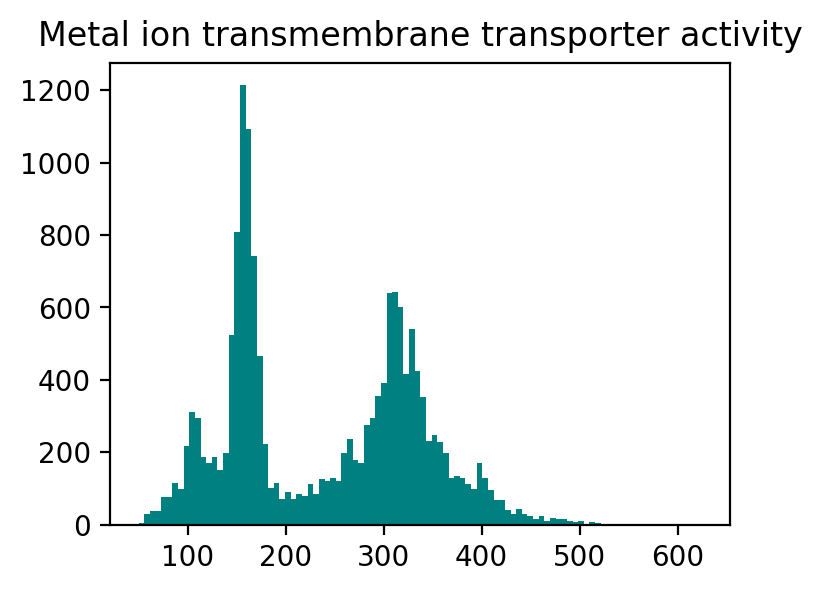

In [30]:
_ = plt.hist(tmp.seq_len, bins=100, color='teal')
plt.title("Metal ion transmembrane transporter activity")

In [41]:
def len_is_between(x, minv, maxv):
    return minv <= x < maxv

In [47]:
sample_len = 72

In [49]:
tmptmp = tmp[tmp.seq_len.map(lambda x: len_is_between(x, 72 * 2 - 10, 72 * 2 + 10))]

In [51]:
tmp.pfam_id.unique()

array(['PF11435', 'PF15247', 'PF01668', 'PF21138', 'PF05733', 'PF02926',
       'PF01818', 'PF05731', 'PF16714', 'PF04146'], dtype=object)